This vignette is part of the workshop: [Hands-on Tour of the Visium Spatial Gene Expression Analysis Journey](link).

We will begin by installing the necessary packages.

In [3]:
install.packages("remotes")
install.packages("devtools")
system("apt install libgsl-dev", intern=TRUE)
devtools::install_github("paulponcet/lplyr")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = '3.19',ask = FALSE)

BiocManager::install("clusterProfiler")
BiocManager::install("enrichplot")
BiocManager::install("ggplot2")
BiocManager::install("msigdbr")
BiocManager::install("dplyr")
BiocManager::install("DOSE")
BiocManager::install("forcats")
BiocManager::install("AnnotationDbi")
BiocManager::install("org.Hs.eg.db")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl27 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

lobstr   (NA -> 1.1.2 ) [CRAN]
pryr     (NA -> 0.1.6 ) [CRAN]
plyr     (NA -> 1.8.9 ) [CRAN]
kimisc   (NA -> 0.4   ) [CRAN]
lazyeval (NA -> 0.2.2 ) [CRAN]
bazar    (NA -> 1.0.11) [CRAN]


Installing 6 packages: lobstr, pryr, plyr, kimisc, lazyeval, bazar

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp1FbrzQ/remotes11751fd1435/paulponcet-lplyr-51a576b/DESCRIPTION’ ... OK
* preparing ‘lplyr’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘lplyr_0.1.12.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'clusterProfiler'

also installing the dependencies ‘zlibbioc’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘formatR’, ‘XVector’, ‘GenomeInfoDb’, ‘lambda.r’, ‘futile.options’, ‘gridGraphics’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘gridExtra’, ‘RcppArmadillo’, 

Next, load these required packages into the environment.

In [4]:
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(msigdbr)
library(dplyr)
library(lplyr)
library(DOSE)
library(forcats)
library(AnnotationDbi)
library(org.Hs.eg.db)



clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

Guangchuang Yu, Li-Gen Wang, Yanyan Han and Qing-Yu He.
clusterProfiler: an R package for comparing biological themes among
gene clusters. OMICS: A Journal of Integrative Biology. 2012,
16(5):284-287


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lplyr’


The following object is masked from ‘package:dplyr’:

    pull


DOSE v3.30.5  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformat

Read the in CSV file containing gene expression information and take a look at the dataframe

In [5]:
download.file("https://raw.githubusercontent.com/10XGenomics/analysis_guides/main/Visium_HD_GSEA/All_gene_exp_ROI.csv", "All_gene_exp_ROI.csv")
df <- read.csv("All_gene_exp_ROI.csv", header = TRUE)
head(df)

,SYMBOL,Log2FC
,<chr>,<dbl>
1,IGHG1,-6.801943
2,IGKC,-6.753258
3,IGFBP3,-6.938455
4,COL1A1,-6.215896
5,COL1A2,-6.217836
6,COL3A1,-6.073149


How many genes are in our list?

In [40]:
nrow(df)

[1] 18072

GSEA requires Entrez IDs as input. These are unique integer identifiers for genes from NCBI. We will use AnnotationDbi to find the IDs for each gene symbol in our list and take a look at the top of the data frame to see what it looks like.

In [39]:
entrez_data <- AnnotationDbi::select(org.Hs.eg.db, keys = df$SYMBOL,columns = c("SYMBOL", "ENTREZID"),keytype = "SYMBOL")
head(entrez_data)

'select()' returned many:many mapping between keys and columns



,SYMBOL,ENTREZID
,<chr>,<chr>
1,IGHG1,3500
2,IGKC,3514
3,IGFBP3,3486
4,COL1A1,1277
5,COL1A2,1278
6,COL3A1,1281


[1] 18072

Not every gene symbol has an associated Entrez ID. We will need to remove genes that do not have an Entrez ID ("NA") from our input list.

In [41]:
anno_result <- entrez_data %>%
  filter(!is.na(ENTREZID)) %>%
  inner_join(df, by = "SYMBOL",relationship = "many-to-many")

head(anno_result)

,SYMBOL,ENTREZID,Log2FC
,<chr>,<chr>,<dbl>
1,IGHG1,3500,-6.801943
2,IGKC,3514,-6.753258
3,IGFBP3,3486,-6.938455
4,COL1A1,1277,-6.215896
5,COL1A2,1278,-6.217836
6,COL3A1,1281,-6.073149


How many genes were removed due to NAs?

In [42]:
nrow(anno_result)

[1] 17635

The starting gene number was 18,072. So, we removed 437 or ~2% of our gene list due to NAs. This is not a large proportion of our gene list and so we will proceed assuming the list is still representative of our sample.

Next, we will turn this data frame into a named vector that has the Entrez ID and associated Log2FC information and sort it smallest Log2FC to largest.

In [47]:
geneList <- with(anno_result, setNames(Log2FC, ENTREZID))
geneList <- sort(geneList, decreasing = TRUE)

Next, we need to prepare our reference gene sets that we will use for analysis. There are a number of databases available to use. We chose to use a popular one, Gene Ontology: Molecular Function. We can access the gene sets in this database with the msigdbr package from MSigDB. To learn more about the gene sets available through this resource, go to this web page: https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp

In [44]:
go_t2g <- msigdbr(species = "Homo sapiens", category = "C5", subcategory = "GO:MF") %>%
  dplyr::select(gs_name, entrez_gene)
head(go_t2g)

gs_name,entrez_gene
<chr>,<int>
GOMF_11_CIS_RETINAL_BINDING,24
GOMF_11_CIS_RETINAL_BINDING,339761
GOMF_11_CIS_RETINAL_BINDING,23596
GOMF_11_CIS_RETINAL_BINDING,94233
GOMF_11_CIS_RETINAL_BINDING,221391
GOMF_11_CIS_RETINAL_BINDING,6010


Now that we have our ranked gene list and gene set reference inputs, we can run GSEA.

In [11]:
go <- GSEA(geneList, TERM2GENE = go_t2g)
go

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (36.2% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 25 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSi

#
# Gene Set Enrichment Analysis
#
#...@organism 	 UNKNOWN 
#...@setType 	 UNKNOWN 
#...@geneList 	 Named num [1:17635] 4.26 3.93 3.81 3.53 3.51 ...
 - attr(*, "names")= chr [1:17635] "27178" "84654" "7137" "56961" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...147 enriched terms found
'data.frame':	147 obs. of  11 variables:
 $ ID             : chr  "GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT_CONFERRING_TENSILE_STRENGTH" "GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT" "GOMF_INTEGRIN_BINDING" "GOMF_CYTOKINE_BINDING" ...
 $ Description    : chr  "GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT_CONFERRING_TENSILE_STRENGTH" "GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT" "GOMF_INTEGRIN_BINDING" "GOMF_CYTOKINE_BINDING" ...
 $ setSize        : int  41 172 153 138 124 135 226 160 224 497 ...
 $ enrichmentScore: num  -0.824 -0.721 -0.67 -0.66 -0.662 ...
 $ NES            : num  -2.2 -2.12 -1.97 -1.94 -1.94 ...
 $ pvalue         : num  1e-10 1e-10 1e-10 1e-10

The gene information is stored as Entrez ID, so we need to add the gene symbols into the go object to be able to interpret the results better. We will also put our results into a dataframe so they are easier to navigate.

In [48]:
go <- setReadable(go, 'org.Hs.eg.db', 'ENTREZID')
go_df <- go@result

Our analysis is complete and stored in an object we called “go”. There were 147 enriched terms found in our data. We can use the object storing the results to generate some plots of our results.

First we will take a look at the overall summary results. We can visualize the top 5 gene sets that were up-regulated (activated), meaning these gene sets were enriched at the top of our list, where up-regulated genes were located. These are genes that are enriched in the tumor. And we will also visualize the top 5 gene sets that were down-regulated (suppressed), meaning these gene sets were enriched at the bottom of our list, where down-regulated genes were located. These are genes that are enriched in the periphery.

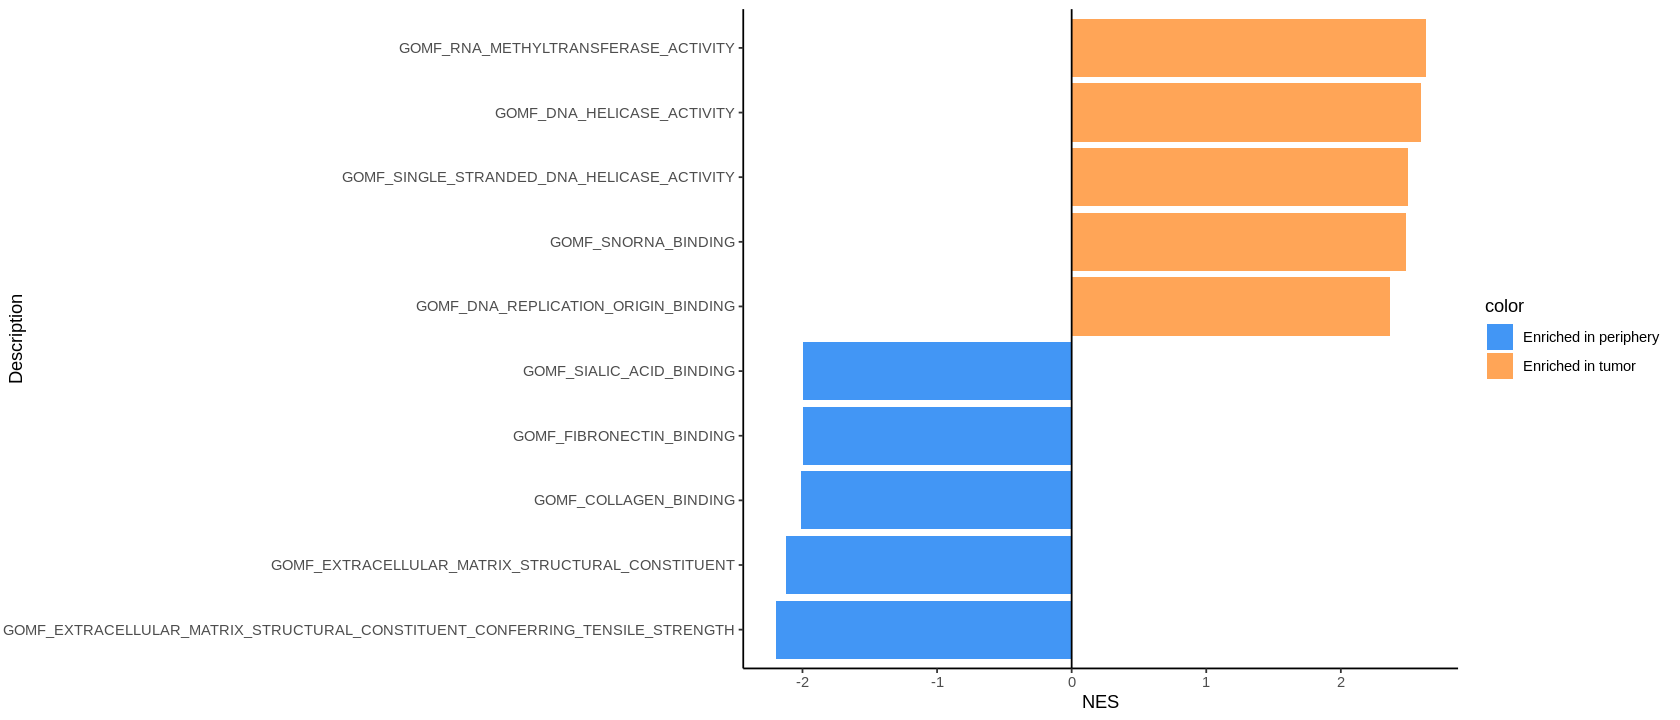

In [77]:
#set plot size
options(repr.plot.width=14, repr.plot.height=6)

#sort results by positive versus negative enrichment, which tells us which
#pathways are enriched inside the tumor versus in the periphery
sorted_go<- go@result[order(go@result$NES, decreasing = F),]
sorted_go$color<-ifelse(sorted_go$NES<0, "Enriched in periphery", "Enriched in tumor")

sorted_go %>%
  dplyr::group_by(color) %>%
  dplyr::arrange(desc(abs(NES))) %>%
  slice_head(n = 5) %>%
  ggplot(aes(x = NES, y = reorder(Description, NES), fill = color)) +
  geom_bar(stat = "identity") +
  geom_vline(xintercept = 0) +
  labs(y = "Description") +
  theme_classic() +
  scale_fill_manual(values=c("#4296f5","#ffa557")) +
  theme(legend.position = "right")

#save a publicaiton-quality version of the plot
ggsave("go_barplot.pdf",
        dpi = 600,
        width = 30, height = 15, unit = "cm")

*Note that all of the gene sets begin with “GOMF” because we utilized the Gene Ontology (GO) database and specifically the Molecular Function (MF) sub-category.*

Next, we can select one of these gene sets to explore more in-depth. Let’s focus on DNA Helicase Activity. We can take a look at our ranked gene list compared to this gene set using a GSEA Plot.

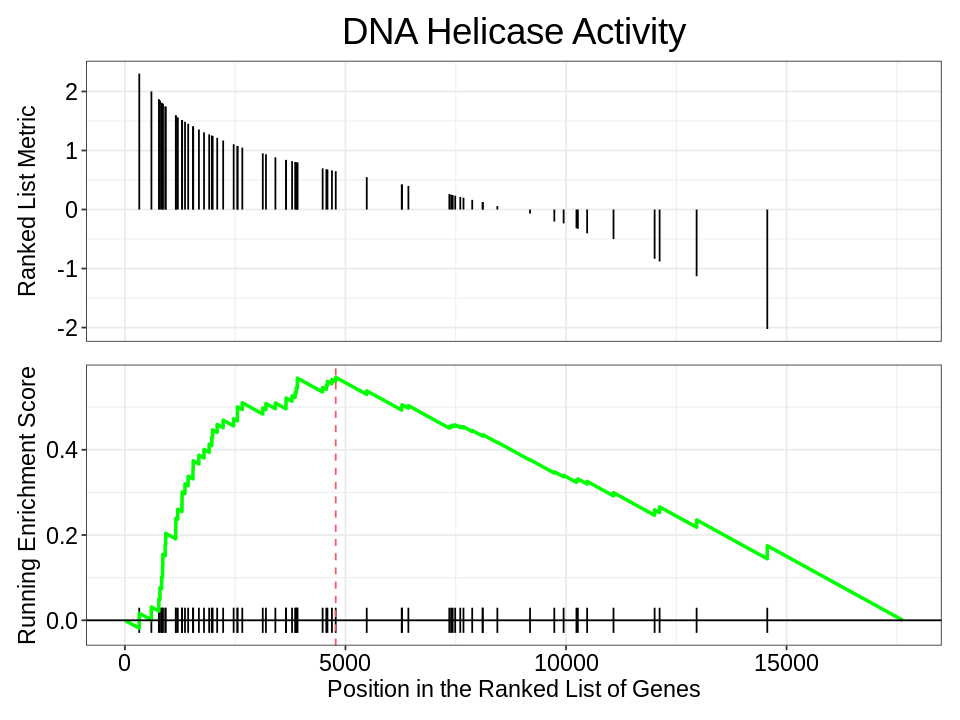

In [28]:
#re-set plot size
options(repr.plot.width=8, repr.plot.height=6)

#gsea plot
gseaplot(go, by = "all", title = "DNA Helicase Activity", geneSetID = "GOMF_DNA_HELICASE_ACTIVITY")

And pull out the NES and adjusted p-value associated with this enriched set.

In [58]:
go_df["GOMF_DNA_HELICASE_ACTIVITY",]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GOMF_DNA_HELICASE_ACTIVITY,GOMF_DNA_HELICASE_ACTIVITY,GOMF_DNA_HELICASE_ACTIVITY,69,0.5698379,2.598522,3.380392e-10,2.881784e-08,2.250629e-08,4779,"tags=64%, list=27%, signal=47%",RECQL4/MCM4/MCM8/RAD54L/RAD51/RAD54B/MCM2/DQX1/RFC5/ERCC6L/POLQ/CHD7/CHTF18/DSCC1/RECQL5/MCM7/MRE11/RUVBL1/GTF2F2/CHD6/RFC3/RFC4/MCM3/RUVBL2/BRIP1/BLM/FANCM/TWNK/MCM5/MCM6/DHX9/DHX36/DNA2/WRNIP1/ZRANB3/CHD2/XRCC6/UPF1/MCM9/RAD50/RAD54L2/ERCC2/SUPV3L1/DDX3X


Our results thus far have confirmed what we might expect in the tumor microenvironment. We have dysregulated DNA replication within the tumor and we have activity related to known cell types outside the tumor. The gene set reference we used is fairly generic. We may get more specific and targeted results using a database that is more relevant to our experiment.

If we go to the GSEA website to browse other databases available for GSEA through MSigDB, we find there is a database of computational gene sets defined by expression neighborhoods centered around cancer-associated genes. Performing GSEA with this database may give us more insightful results.

In [69]:
c4_t2g <- msigdbr(species = "Homo sapiens", category = "C4", subcategory = "CGN") %>%
  dplyr::select(gs_name, entrez_gene)
c4 <- GSEA(geneList, TERM2GENE = c4_t2g)

c4 <- setReadable(c4, 'org.Hs.eg.db', 'ENTREZID')
c4_df <- c4@result

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (36.2% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 59 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSi

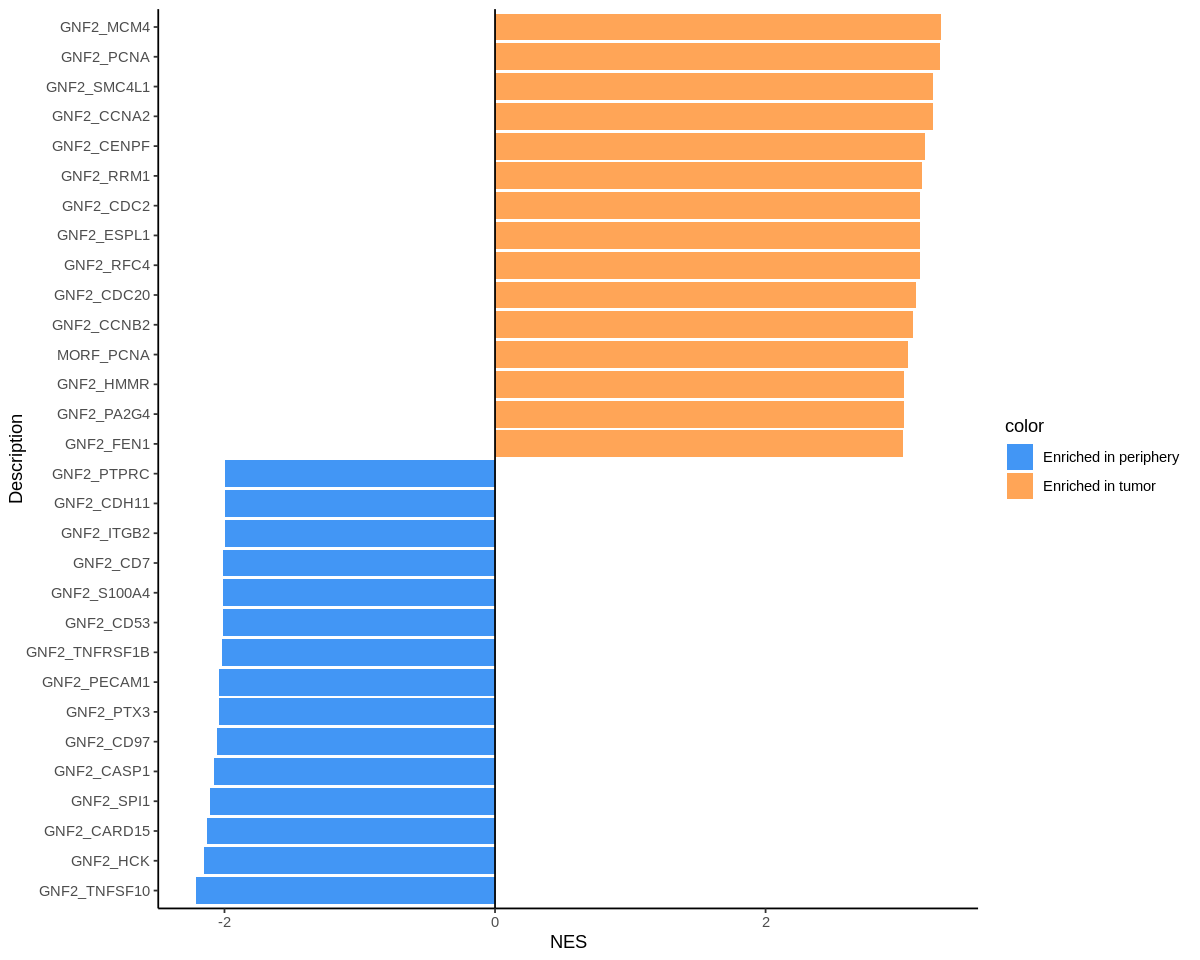

In [75]:
#re-set plot size
options(repr.plot.width=10, repr.plot.height=8)

sorted_c4<- c4@result[order(c4@result$NES, decreasing = F),]
sorted_c4$color<-ifelse(sorted_c4$NES<0, "Enriched in periphery", "Enriched in tumor")

sorted_c4 %>%
  dplyr::group_by(color) %>%
  dplyr::arrange(desc(abs(NES))) %>%
  slice_head(n = 15) %>%
  ggplot(aes(x = NES, y = reorder(Description, NES), fill = color)) +
  geom_bar(stat = "identity") +
  geom_vline(xintercept = 0) +
  labs(y = "Description") +
  theme_classic() +
  scale_fill_manual(values=c("#4296f5","#ffa557")) +
  theme(legend.position = "right")

#save a publicaiton-quality version of the plot
ggsave("c4_barplot.pdf",
        dpi = 600,
        width = 20, height = 15, unit = "cm")

The database we are using organizes the gene pathways into sets of genes centered around known cancer-related genes. We will need to make use of the GSEA website to understand what each gene set is.

For example, looking into one of the modules enriched in the Periphery region, [GNF2_PECAM1](https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GNF2_PECAM1.html), we can learn more about it.

Let's take a deeper look at the enrichment results and where PECAM1 network genes fall in our ranked gene list.

In [70]:
#Pull out NES and adjusted p-value for PECAM1 network
c4_df["GNF2_PECAM1",]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GNF2_PECAM1,GNF2_PECAM1,GNF2_PECAM1,53,-0.7405957,-2.038735,7.184055e-10,6.708473e-09,2.913372e-09,2088,"tags=60%, list=12%, signal=53%",TCIRG1/PSAP/S100A4/ADA2/RGS2/DUSP1/TLR8/LILRA1/TLR2/CLEC4A/NCF2/TNFAIP2/THEMIS2/CCR1/AIF1/LILRA6/LST1/CHST15/HCK/FCER1G/IGSF6/MAFB/TYROBP/CYBB/TYMP/MS4A6A/LILRA2/FGL2/LILRB2/ITGB2/PECAM1/CD93


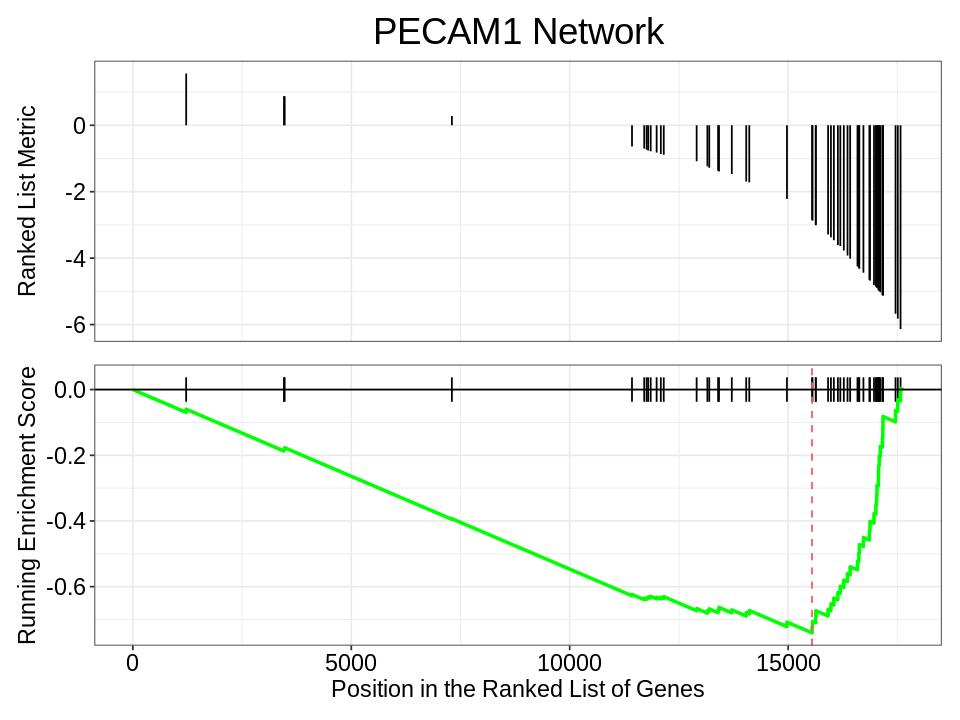

In [71]:
#re-set plot size
options(repr.plot.width=8, repr.plot.height=6)

gseaplot(c4, by = "all", title = "PECAM1 Network", geneSetID = "GNF2_PECAM1")

Of the 53 genes in this PECAM1 Gene Set, 32 were detected in our experiment. We can also take a look at the specific genes in this network and how they were expressed in our data. Notably,

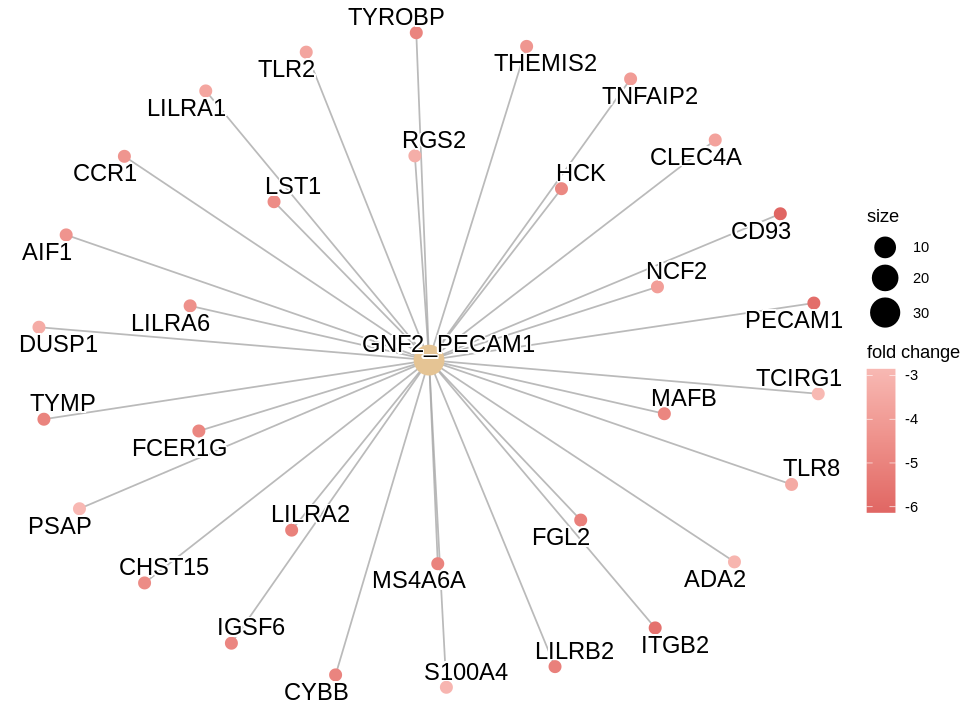

In [72]:
cnetplot(c4, categorySize="pvalue", color.params = list(foldChange=geneList), showCategory = c("GNF2_PECAM1"))

Going to the literature, this gene has been studied in the cancer field. Specifically, [one study](https://doi.org/10.1073/pnas.1004654107) found that PECAM-1 in the tumor microenvironment drives advanced metastatic progression of tumor cells. [Another](https://doi.org/10.1023/A:1009092107382) found that an antibody against murine PECAM-1 inhibits tumor angiogenesis in mice.

We may find promising cancer treatment targets by looking at the genes in this gene set. The last thing we will do is go back to Loupe Browser to visualize the expression of these genes in our tissue.

In [23]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] org.Hs.eg.db_3.19.1    AnnotationDbi_1.66.0   IRanges_2.38.1        
 [4] S4Vectors_0.42.1       Biobase_2.64.0         BiocGenerics_0.50.0   
 [7] forcats_1.0.